# Import libraries

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.metrics import log_loss
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.model_selection import GridSearchCV,KFold,LeaveOneOut

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

from sklearn.manifold import Isomap
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
import umap

# Define functions

In [21]:
def ConvertLabels(labels):
    #labels = np.asarray(labels)
    #for label in range(len(labels))
     #   print(label)
    column_name = 'label'
    labels.loc[colon_label[column_name] > 0] = 1
    labels.loc[colon_label[column_name] < 0] = 0
    
    return labels

In [33]:
def scatter_2d_label(X_2d, y, s=2, alpha=0.5, lw=2):
    """Visualuse a 2D embedding with corresponding labels.
    
    X_2d : ndarray, shape (n_samples,2)
        Low-dimensional feature representation.
    
    y : ndarray, shape (n_samples,)
        Labels corresponding to the entries in X_2d.
        
    s : float
        Marker size for scatter plot.
    
    alpha : float
        Transparency for scatter plot.
        
    lw : float
        Linewidth for scatter plot.
    """
    targets = np.unique(y)
    colors = sns.color_palette(n_colors=targets.size)
    for color, target in zip(colors, targets):
        plt.scatter(X_2d[y == target, 0], X_2d[y == target, 1], color=color, label=target, s=s, alpha=alpha, lw=lw)

In [38]:
def scatter_3d_label(X_3d, y, fig=None, s=2, alpha=0.5, lw=2):
    """Visualuse a 3D embedding with corresponding labels.
    
    X_3d : ndarray, shape (n_samples,3)
        Low-dimensional feature representation.
    
    y : ndarray, shape (n_samples,)
        Labels corresponding to the entries in X_3d.
        
    s : float
        Marker size for scatter plot.
    
    alpha : float
        Transparency for scatter plot.
        
    lw : float
        Linewidth for scatter plot.
    """
    from mpl_toolkits.mplot3d import Axes3D
    if fig is None:
        fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111, projection='3d')

    targets = np.unique(y)
    colors = sns.color_palette(n_colors=targets.size)
    for color, target in zip(colors, targets):
        ax.scatter(X_3d[y == target, 0], X_3d[y == target, 1], X_3d[y == target, 2], 
                    color=color, s=s, label=target, alpha=alpha, lw=lw)
    return (fig, ax)

# Read data

In [27]:
colon       = pd.read_csv('colonCancerData.csv', index_col=0)
colon_label = pd.read_csv('label.csv')
colon_label = ConvertLabels(colon_label).squeeze(1)
data_label  = pd.concat([colon, colon_label], axis = 1, sort= False)

In [29]:
print('colon.shape:', colon.shape)
print('colon_label.shape', colon_label.shape)
print('data_label.shape', data_label.shape)

colon.shape: (62, 2000)
colon_label.shape (62,)
data_label.shape (62, 2001)


# Preprocess data

In [30]:
scaler   = StandardScaler()
colon_sc = scaler.fit_transform(colon)

In [31]:
colon_sc.shape

(62, 2000)

# Visualize data

## MDS 2D

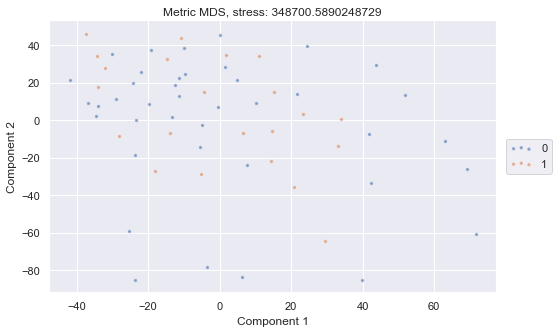

In [37]:
sns.set(font_scale=1.)
mds = MDS(n_components=2, metric=True, n_init=1, max_iter=100, random_state=10)
colon_mds_2d = mds.fit_transform(colon_sc)
plt.figure(figsize=(8,5))
scatter_2d_label(colon_mds_2d, colon_label)
plt.title('Metric MDS, stress: {}'.format(mds.stress_))
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(loc='center left', bbox_to_anchor=[1.01, 0.5], scatterpoints=3)
plt.show()

## MDS 3D

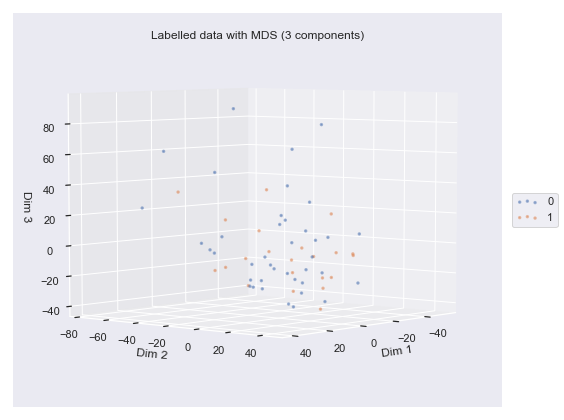

In [39]:
mds_3_comp = MDS(n_components=3, metric=True, n_init=1, max_iter=100, random_state=10)
colon_mds_3d = mds_3_comp.fit_transform(colon_sc)

fig = plt.figure(figsize=(8,6))
_, ax = scatter_3d_label(colon_mds_3d, colon_label, fig=fig)
ax.set_xlabel('Dim 1')
ax.set_ylabel('Dim 2')
ax.set_zlabel('Dim 3')
ax.set_title('Labelled data with MDS (3 components)')
ax.legend(loc='center left', bbox_to_anchor=[1.01, 0.5], scatterpoints=3)
ax.azim = 400
ax.elev = 5
fig.tight_layout()
plt.show()

## MDS cosine distance

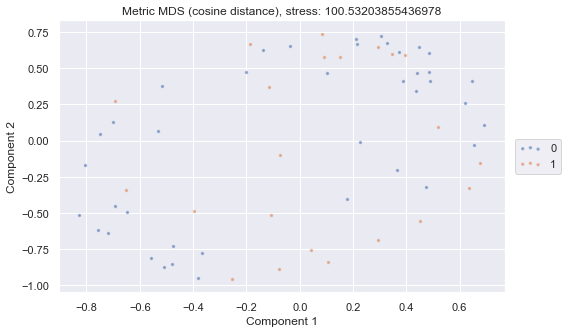

In [41]:
similarities = pairwise_distances(X=colon_sc, metric='cosine')
sns.set(font_scale=1.)
plt.figure(figsize=(8,5))
mds = MDS(n_components=2, metric=True, dissimilarity='precomputed', n_init=1, max_iter=100)
colon_mds_2d = mds.fit_transform(similarities)
scatter_2d_label(colon_mds_2d, colon_label)
plt.title('Metric MDS (cosine distance), stress: {}'.format(mds.stress_))
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(loc='center left', bbox_to_anchor=[1.01, 0.5], scatterpoints=3)
plt.show()

## Isomap

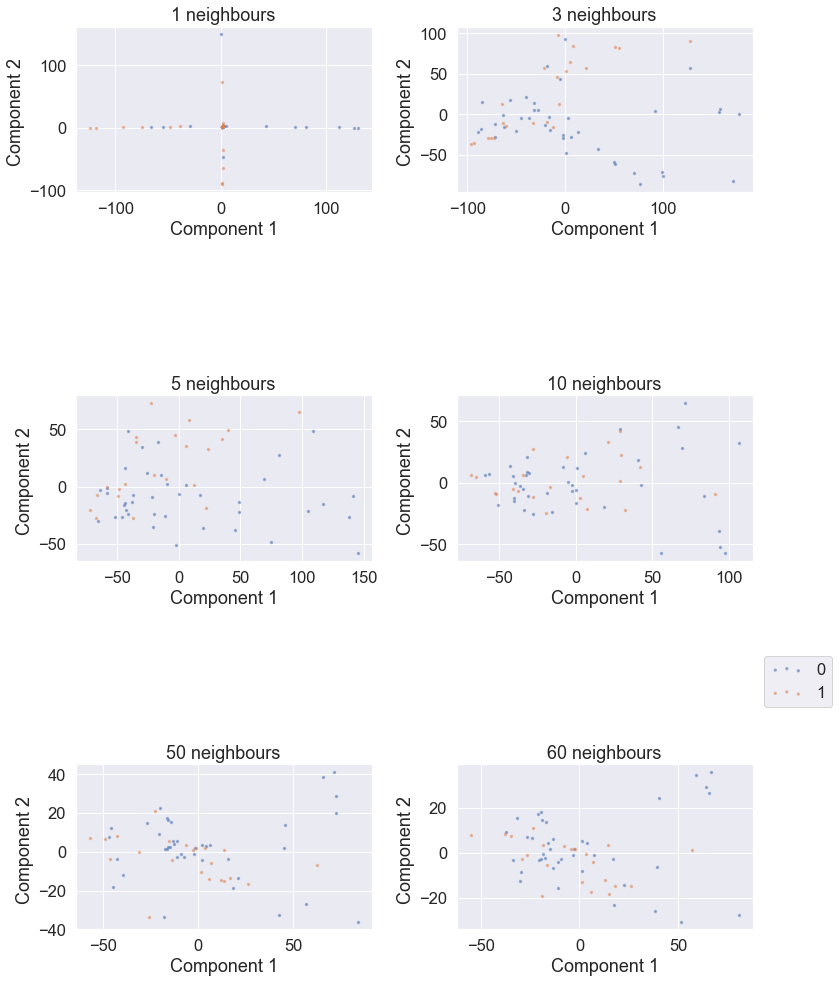

In [35]:
sns.set(font_scale=1.5) # Set default font size
fig, ax = plt.subplots(3,2,figsize=(12,14))
for ii, n_neighbors in enumerate([1, 3, 5, 10, 50, 60]):
    ismp = Isomap(n_components=2, n_neighbors=n_neighbors)
    colon_ismp_2d = ismp.fit_transform(colon_sc)
    plt.subplot(3,2,ii+1)
    scatter_2d_label(colon_ismp_2d, colon_label)
    plt.title('{} neighbours'.format(n_neighbors))
    plt.xlabel('Component 1')
    plt.ylabel('Component 2 ')
plt.legend(loc='center left', bbox_to_anchor=[1.01, 1.5], scatterpoints=3)
fig.tight_layout()
plt.show()

## T-SNE

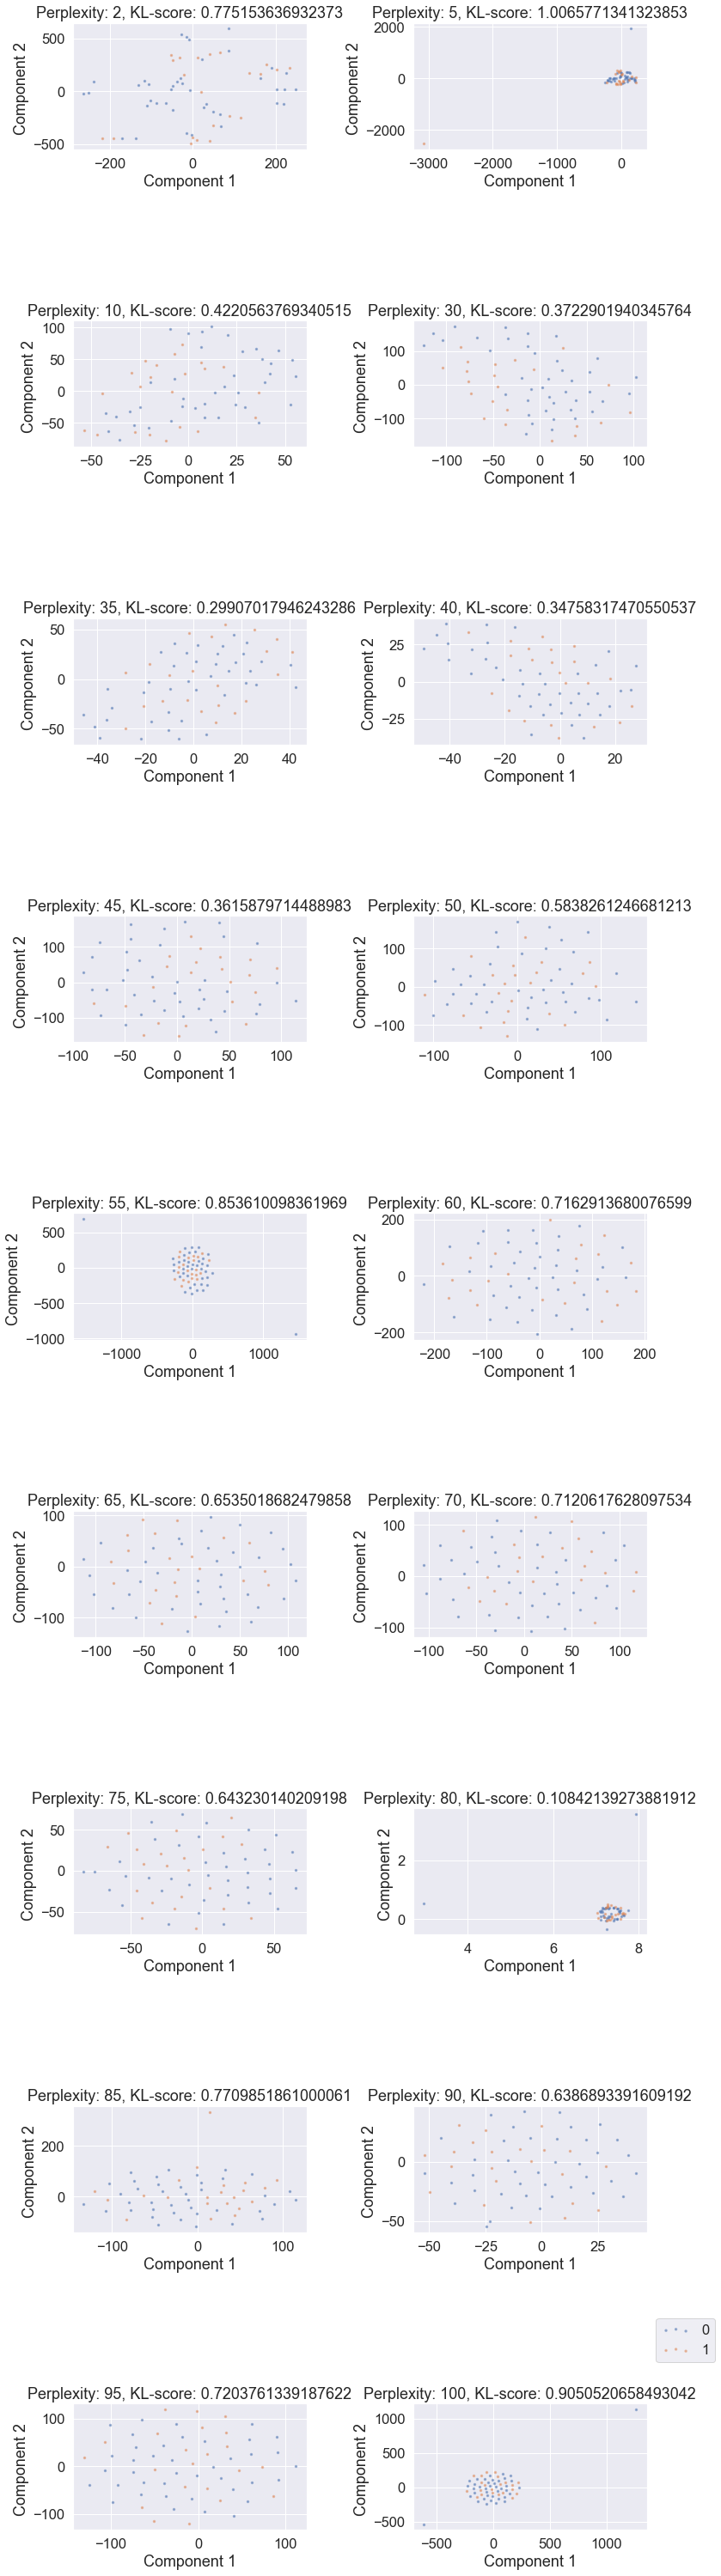

In [52]:
sns.set(font_scale=1.5) # Set default font size
fig, ax = plt.subplots(9,2,figsize=(12,42))
for ii, perplexity in enumerate([2, 5, 10, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]):
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=10)
    colon_tsne_2d = tsne.fit_transform(colon_sc)
    plt.subplot(9,2,ii+1)
    scatter_2d_label(colon_tsne_2d, colon_label)
    plt.title('Perplexity: {}, KL-score: {}'.format(perplexity, tsne.kl_divergence_))
    plt.xlabel('Component 1')
    plt.ylabel('Component 2 ')
plt.legend(loc='center left', bbox_to_anchor=[1.01, 1.5], scatterpoints=3)
fig.tight_layout()
plt.show()

## T-SNE 3D

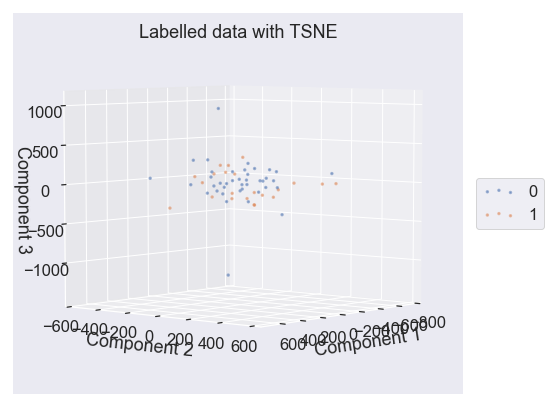

In [63]:
tsne_3_comp = TSNE(n_components=3, perplexity=30, random_state=10)
colon_tsne_3d = tsne_3_comp.fit_transform(colon_sc)

fig = plt.figure(figsize=(8,6))
_, ax = scatter_3d_label(colon_tsne_3d, colon_label, fig=fig)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
ax.set_title('Labelled data with TSNE')
ax.legend(loc='center left', bbox_to_anchor=[1.01, 0.5], scatterpoints=3)
ax.azim = 400
ax.elev = 5
fig.tight_layout()
plt.show()





## UMAP

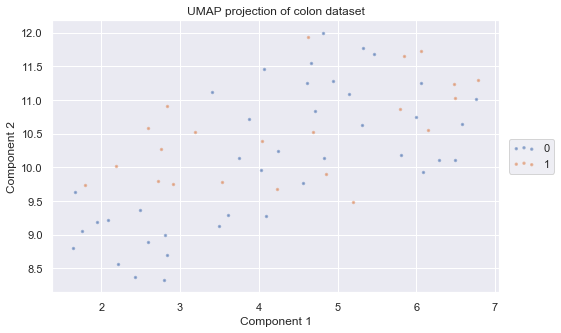

In [101]:
sns.set(font_scale=1.)
reducer = umap.UMAP()
colon_umap = reducer.fit_transform(colon_sc)
plt.figure(figsize=(8,5))
scatter_2d_label(colon_umap, colon_label)
plt.title('UMAP projection of colon dataset')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(loc='center left', bbox_to_anchor=[1.01, 0.5], scatterpoints=3)
plt.show()